# Prediction of Two Droplets
- Condition
    - paraffin: 20
    - ES volume: 10
    - n_droplets: 2
    - Dye conc.: 0.005
    - SDS conc.: 18
    - Solution volume: 30
    - Temp.: 25

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms
from torchinfo import summary # ニューラルネットワークの中身を見る

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import os
import random

# 乱数固定用の処理
# 同じ学習結果を得る
seed = 10

# シードを固定するための関数
def torch_fix_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms = True
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

torch_fix_seed(seed)

In [8]:
def mk_dataframe(path):
    df = pd.read_table(path, sep=" ", header=None)
    df = df.drop(columns=0, axis=1)
    df = df.drop(columns=df.shape[1], axis=1)
    return df

df = mk_dataframe("230927/pos-1.dat")

In [9]:
df

,1,2,3,4
0,6.213982,-19.842319,-3.713528,17.819865
1,6.223218,-19.851964,-3.728667,17.823444
2,6.215443,-19.810296,-3.712737,17.835844
3,6.224143,-19.834000,-3.743289,17.844333
4,6.236036,-19.846224,-3.746192,17.836633
...,...,...,...,...
35995,-12.792174,-24.929617,-28.724368,-2.128973
35996,-12.786463,-24.935039,-28.705184,-2.096358
35997,-12.776513,-24.960743,-28.727444,-2.115000
35998,-12.781526,-24.946281,-28.722109,-2.100696


In [10]:
df_ = df.values

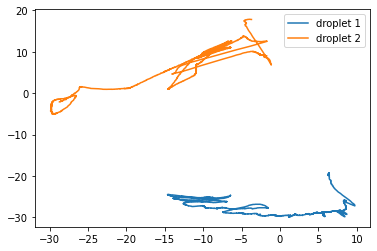

In [14]:
plt.plot(df_[:36000:10, 0], df_[:36000:10, 1], label="droplet 1")
plt.plot(df_[:36000:10, 2], df_[:36000:10, 3], label="droplet 2")
plt.legend()

In [39]:
# 正規化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

# 1度arrayを1列にしてから正規化
df_scaled = scaler.fit_transform(df_.reshape(-1, 1))

In [42]:
df_scaled = df_scaled.reshape(-1, 4)

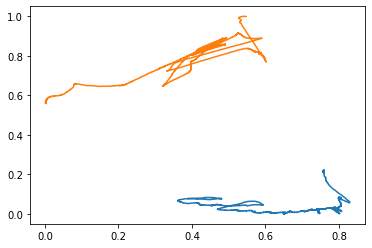

In [44]:
plt.plot(df_scaled[:30000:10, 0], df_scaled[:30000:10, 1])
plt.plot(df_scaled[:30000:10, 2], df_scaled[:30000:10, 3])

## データ分割

In [52]:
data = df_scaled[:10000:10]

train_size = int(len(data) * 0.7)
test_size = len(data) - train_size

print("train size: {}, test size:{}".format(train_size, test_size))

train size: 700, test size:300


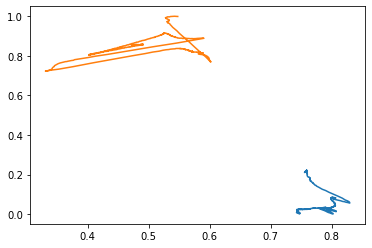

In [53]:
plt.plot(data[:, 0], data[:, 1])
plt.plot(data[:, 2], data[:, 3])

In [54]:
# 何個のデータを用いて次の時刻を予測
time_step = 50
n_sample = train_size - time_step - 1

#シーケンシャルデータを格納する箱を用意(入力)
input_data = np.zeros((n_sample, time_step, 4))
#シーケンシャルデータを格納する箱を用意(正解)
correct_input_data = np.zeros((n_sample, 4))

print(input_data.shape)
print(correct_input_data.shape)

(649, 50, 4)
(649, 4)


In [55]:
for i in range(n_sample):
    input_data[i] = data[i:i+time_step, :].reshape(-1, 4)
    correct_input_data[i] = data[i+time_step:i+time_step+1, :]

In [56]:
# -----データローダ-----
input_data = torch.tensor(input_data, dtype=torch.float) #Tensor化(入力)
correct_data = torch.tensor(correct_input_data, dtype=torch.float) #Tensor化(正解)

dataset = torch.utils.data.TensorDataset(input_data, correct_data) #データセット作成

n_sample_train = len(dataset)
n_train = int(n_sample * 0.8)
n_val = n_sample_train - n_train

print("n_train:{}, n_val:{}".format(n_train, n_val))

train_dataset, val_dataset = torch.utils.data.random_split(dataset,
                                                           [n_train, n_val], 
                                                           generator=torch.Generator().manual_seed(seed))

# ------データローダの再現性担保-----
def seed_worker(worker_id):
    worker_seed = torch.initial_seed()

    # Seed other libraries with torch's seed
    random.seed(worker_seed)

    # Numpy seed must be between 0 and 2**32 - 1
    if worker_seed >= 2 ** 32:
        worker_seed = worker_seed % 2 ** 32
    np.random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)
# -------------------------------


# datasetからバッチごとに取り出す
train_loader = DataLoader(
                            train_dataset,
                            batch_size=4,
                            shuffle=True,
                            num_workers=2,
                            worker_init_fn=seed_worker,
                            generator=g,
                        )

val_loader = DataLoader(
                            val_dataset,
                            batch_size=4,
                            shuffle=True,
                            num_workers=2,
                            worker_init_fn=seed_worker,
                            generator=g,
                        )

n_train:519, n_val:130


## Early Stopping

In [57]:
class EarlyStopping:
    """earlystoppingクラス"""

    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float("inf")
        self.patience = patience
        self.verbose = verbose
        
    def __call__(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print("early stopping")
                return True

        else:
            self._step = 0
            self._loss = loss

        return False

# Model

In [58]:
class GRU(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
        super(GRU, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        y_gru, h = self.gru(x, None)
        y = self.fc(y_gru[:, -1, :])
        
        return y

## 学習

In [59]:
def train_func(net, epoch=100):
    loss_func = nn.MSELoss(reduction="mean")

    optimizer = optim.Adam(net.parameters(), lr=0.001)

    device = torch.device("cuda:0" if torch.cuda. is_available() else "cpu")  #デバイス(GPU or CPU)設定 
    
    hist = {"train_loss":[], 
            "val_loss":[]}

    epochs = 100 #エポック数

    net.to(device)

    es = EarlyStopping(patience=5, verbose=1)

    for i in range(epochs):
        net.train()
        running_loss = 0.0
        running_val_loss = 0.0

        for j, (x, t) in enumerate(train_loader):
            x = x.to(device)
            optimizer.zero_grad()

            y = net(x)
            y = y.to(device)

            loss = loss_func(y, t)
            loss.backward()

            optimizer.step()
            running_loss += loss.item()

        running_loss /= j + 1
        hist["train_loss"].append(running_loss)
        
        for j, (x, t) in enumerate(val_loader):
            x, t = x.to(device), t.to(device)
            
            net.eval()
            
            pred = net(x)
            loss = loss_func(pred, t)
            running_val_loss += loss.item()
            
        running_val_loss /= j + 1
        hist["val_loss"].append(running_val_loss)


        if i%5 == 0 or i==epochs-1:
            print("Epoch:{}, Train_Loss:{:3f}, Val_Loss:{:3f}".format(i, running_loss, running_val_loss))

        if es(running_val_loss):
            print("Epoch:{}, Train_Loss:{:3f}, Val_Loss:{:3f}".format(i, running_loss, running_val_loss))
            break
    
    #lossの推移を確認
    plt.plot(range(len(hist["train_loss"])), hist["train_loss"], label='train loss')
    plt.plot(range(len(hist["val_loss"])), hist["val_loss"], label='val loss')
    
    plt.legend()
    plt.title("Change of Loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

## 予測用関数

In [78]:
def future_prediction(net, data):
    X = data
    net.eval()

    gen = [[None, None, None, None] for i in range(train_size)] # 予測値を時系列で保持するためのリスト

    z = X[train_size:train_size+time_step].reshape(-1, time_step, 4) # 予測用に未知の部分の最初time_step個

    for i in range(test_size):
        z_ = torch.Tensor(z[-1:, :])

        preds = net(z_).data.cpu().numpy()
        z = np.concatenate([z, preds.reshape(-1, 1, 4)], 1)
        z = z[:,1:,:]

        gen.append([preds[0,0], preds[0,1], preds[0,2], preds[0,3]])
        
    print(net)
    
    fig = plt.figure(figsize=(7,7))
    plt.plot(X[:,0], X[:,1], label="Correct for droplet1", alpha=0.6)
    plt.plot(X[:,2], X[:,3], label="Correct for droplet2", alpha=0.6)
    plt.plot(X[:train_size,0], X[:train_size,1], label="train data", color="green")
    plt.plot(X[:train_size,2], X[:train_size,3], color="green")

    gen = np.array(gen)
    plt.plot(gen[:,0], gen[:,1],label='Predicted 1')
    plt.plot(gen[:,2], gen[:,3],label='Predicted 2')
    plt.legend()

    plt.scatter(X[train_size+time_step,0], X[train_size+time_step,1], marker="x")
    plt.scatter(X[train_size+time_step,2], X[train_size+time_step,3], marker="x")
    plt.title("hidden_dim={}".format(net.hidden_dim))
    
    # plt.savefig("output/spiral_hidden{}.png".format(net.hidden_dim))
    plt.show()

## Define Model

In [63]:
input_dim = 4
output_dim = 4
hidden_dim = 64
n_layers = 1

net = GRU(input_dim, output_dim, hidden_dim, n_layers)

batch_size = 4
summary(net, (batch_size, time_step, 4))

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [4, 4]                    --
├─GRU: 1-1                               [4, 50, 64]               13,440
├─Linear: 1-2                            [4, 4]                    260
Total params: 13,700
Trainable params: 13,700
Non-trainable params: 0
Total mult-adds (M): 2.69
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 0.05
Estimated Total Size (MB): 0.16

In [64]:
train_func(net)

GRU(
  (gru): GRU(4, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)


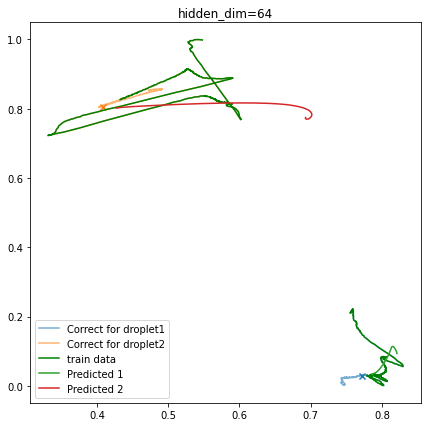

In [79]:
future_prediction(net, data)

Epoch:0, Train_Loss:0.020124, Val_Loss:0.001448
Epoch:5, Train_Loss:0.000399, Val_Loss:0.000498
Epoch:10, Train_Loss:0.000089, Val_Loss:0.000089
Epoch:15, Train_Loss:0.000080, Val_Loss:0.000033
Epoch:20, Train_Loss:0.000063, Val_Loss:0.000044
early stopping
Epoch:21, Train_Loss:0.000044, Val_Loss:0.000065


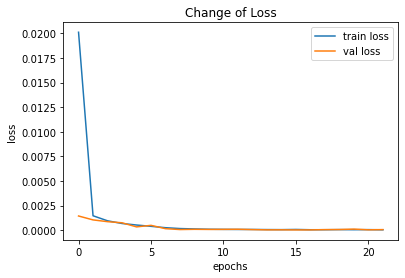

GRU(
  (gru): GRU(4, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)


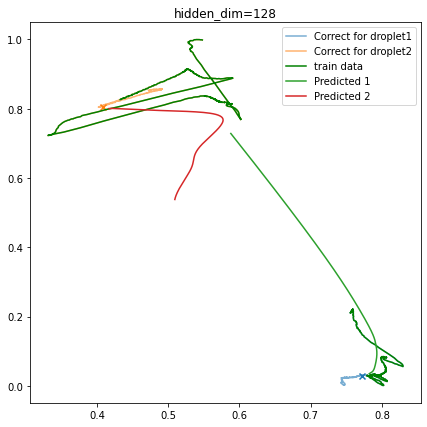

In [81]:
net2 = GRU(4, 4, 128, n_layers)
train_func(net2)
future_prediction(net2, data)

In [73]:
data.shape[-1]

4